<a href="https://colab.research.google.com/github/vienskaz/ECG-CNN/blob/main/EKG_GANfourldim50_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras import layers, models
import seaborn as sns
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense


In [26]:
mit_test_data = pd.read_csv('/content/drive/MyDrive/ecg/mitbih_test.csv', header=None)
mit_train_data = pd.read_csv('/content/drive/MyDrive/ecg/mitbih_train.csv', header=None)

X_train = mit_train_data.iloc[:, :-1].values
y_train = mit_train_data.iloc[:, -1].values
X_test = mit_test_data.iloc[:, :-1].values
y_test = mit_test_data.iloc[:, -1].values

normal = pd.read_csv('/content/drive/MyDrive/ecg/ptbdb_normal.csv', header=None)
abnormal = pd.read_csv('/content/drive/MyDrive/ecg/ptbdb_abnormal.csv', header=None)
X_normal = normal.iloc[:, :-1].values
y_normal = np.zeros(X_normal.shape[0])
X_abnormal = abnormal.iloc[:, :-1].values
y_abnormal = np.ones(X_abnormal.shape[0])

X = np.concatenate([X_normal, X_abnormal], axis=0)
y = np.concatenate([y_normal, y_abnormal], axis=0)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
X = X.reshape((X.shape[0], X.shape[1], 1))

Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)

In [27]:
def moving_average_filter(signal, window_size=5):
    filtered=[]
    for data in signal:
      filtered_ecg = np.convolve(data.flatten(), np.ones(window_size) / window_size, mode='same')
      filtered.append(filtered_ecg)
    return np.array(filtered)


In [28]:
two = []
three = []
four = []
five = []

for i in range(len(Y_train)):
    if np.array_equal(Y_train[i], [0.0, 1.0, 0.0, 0.0, 0.0]):
        two.append(X_train[i])
    elif np.array_equal(Y_train[i], [0.0, 0.0, 1.0, 0.0, 0.0]):
        three.append(X_train[i])
    elif np.array_equal(Y_train[i], [0.0, 0.0, 0.0, 1.0, 0.0]):
        four.append(X_train[i])
    elif np.array_equal(Y_train[i], [0.0, 0.0, 0.0, 0.0, 1.0]):
        five.append(X_train[i])




In [29]:
np.array(two)
np.array(three)
np.array(four )
np.array(five )

array([[[0.71260995],
        [0.62903225],
        [0.52785921],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[1.        ],
        [0.4848485 ],
        [0.54166669],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.58404559],
        [0.5       ],
        [0.42450142],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       ...,

       [[0.90612245],
        [0.62448978],
        [0.59591836],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.85822785],
        [0.64556962],
        [0.84556961],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.90150636],
        [0.84588647],
        [0.80069524],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]]])

In [30]:
print(len(two))
print(len(three))
print(len(four))
print(len(five))

2223
5788
641
6431


In [31]:
two = moving_average_filter(two)
three = moving_average_filter(three)
four = moving_average_filter(four)
five = moving_average_filter(five)

In [ ]:
print(two[0].shape)

(187,)


In [60]:
def build_discriminator(n=187):
    inps = layers.Input(shape=(n,))
    x = Dense(512, activation='relu')(inps)
    x = Dense(512, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    outs = Dense(1, activation='sigmoid')(x)
    model = models.Model(inps, outs, name='discriminator')
    return model

# Generator definition with the correct activation function


def build_generator(latent_dim=50, output_shape=(187, 1)):
    inps = layers.Input(shape=(latent_dim,))
    x = Dense(256, activation='relu')(inps)
    x = Dense(256, activation='relu')(x)
    outs = Dense(187, activation='tanh')(x)
    model = models.Model(inps, outs, name='generator')
    return model



discriminator = build_discriminator()
generator = build_generator(latent_dim=50)
print(discriminator.summary())
print(generator.summary())

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 187)]             0         
                                                                 
 dense_35 (Dense)            (None, 512)               96256     
                                                                 
 dense_36 (Dense)            (None, 512)               262656    
                                                                 
 dense_37 (Dense)            (None, 256)               131328    
                                                                 
 dense_38 (Dense)            (None, 1)                 257       
                                                                 
Total params: 490497 (1.87 MB)
Trainable params: 490497 (1.87 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Model: "gene

In [61]:
class GAN(keras.Model):

    def __init__(self, disc, gen, latent_dim=50):
        super(GAN, self).__init__()
        self.discriminator = disc
        self.generator = gen
        self.latent_dim = latent_dim

    def compile(self, optD, optG, loss_fn):
        super(GAN, self).compile()
        self.optD = optD
        self.optG = optG
        self.loss_fn = loss_fn

    def train_step(self, real_data):
        if isinstance(real_data, tuple):
            real_data = real_data[0]

        bs = tf.shape(real_data)[0]
        z = tf.random.normal(shape=(bs, self.latent_dim))
        fake_data = self.generator(z)

        combined_data = tf.concat([real_data, fake_data], axis=0)
        labels = tf.concat([tf.ones((bs, 1)), tf.zeros((bs, 1))], axis=0)

        with tf.GradientTape() as tape:
            preds = self.discriminator(combined_data)
            d_loss = self.loss_fn(labels, preds)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.optD.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        misleading_labels = tf.ones((bs, 1))
        z = tf.random.normal(shape=(bs, self.latent_dim))

        with tf.GradientTape() as tape:
            fake_preds = self.discriminator(self.generator(z))
            g_loss = self.loss_fn(misleading_labels, fake_preds)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.optG.apply_gradients(zip(grads, self.generator.trainable_weights))

        return {"d_loss": d_loss, "g_loss": g_loss}

gan = GAN(discriminator, generator)

gan.compile(
    optD=keras.optimizers.Adam(learning_rate=0.0001),
    optG=keras.optimizers.Adam(learning_rate=0.001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)


In [62]:
def show_samples(epoch, generator, data, n=187, l_dim=50):
  generated_points_list=[]
  if epoch % 100 == 0:
    z = tf.random.normal(shape=(n, l_dim))
    generated_data = generator(z)
    generated_points_list.append(generated_data)
    plt.plot(generated_data)
    plt.show()


Epoch 1/2000
20/21 [===========================>..] - ETA: 0s - d_loss: 0.7696 - g_loss: 0.5717

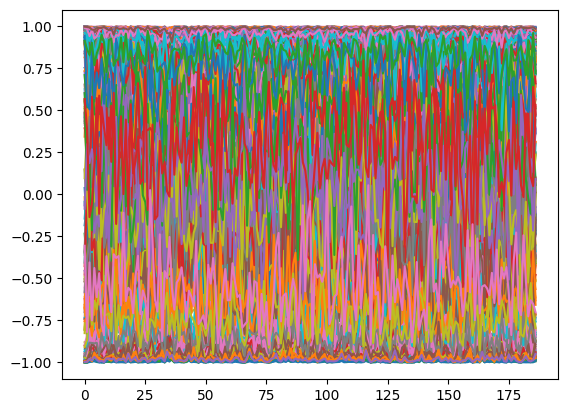

21/21 [==============================] - 3s 55ms/step - d_loss: 0.7420 - g_loss: 0.6164
Epoch 2/2000
21/21 [==============================] - 0s 20ms/step - d_loss: 0.3651 - g_loss: 1.5522
Epoch 3/2000
21/21 [==============================] - 0s 17ms/step - d_loss: 0.2039 - g_loss: 2.7626
Epoch 4/2000
21/21 [==============================] - 0s 19ms/step - d_loss: 0.1834 - g_loss: 3.2330
Epoch 5/2000
21/21 [==============================] - 0s 16ms/step - d_loss: 0.1530 - g_loss: 3.7362
Epoch 6/2000
21/21 [==============================] - 0s 18ms/step - d_loss: 0.1710 - g_loss: 3.8335
Epoch 7/2000
21/21 [==============================] - 0s 17ms/step - d_loss: 0.1161 - g_loss: 4.2356
Epoch 8/2000
21/21 [==============================] - 0s 18ms/step - d_loss: 0.0708 - g_loss: 4.4756
Epoch 9/2000
21/21 [==============================] - 0s 17ms/step - d_loss: 0.1340 - g_loss: 4.8313
Epoch 10/2000
21/21 [==============================] - 0s 18ms/step - d_loss: 0.1393 - g_loss: 5.3615
Ep

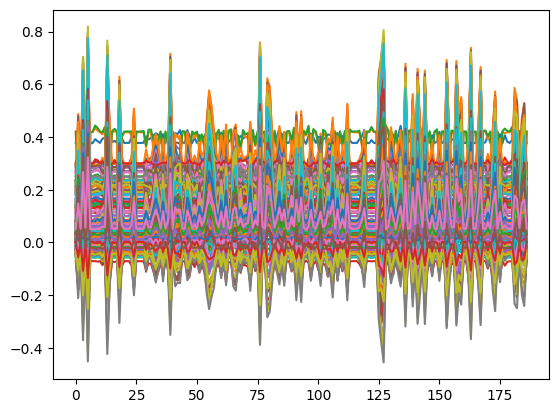

21/21 [==============================] - 1s 52ms/step - d_loss: 0.4204 - g_loss: 1.0816
Epoch 102/2000
21/21 [==============================] - 0s 21ms/step - d_loss: 0.4443 - g_loss: 1.1025
Epoch 103/2000
21/21 [==============================] - 0s 19ms/step - d_loss: 0.5404 - g_loss: 1.0183
Epoch 104/2000
21/21 [==============================] - 0s 21ms/step - d_loss: 0.4801 - g_loss: 1.0183
Epoch 105/2000
21/21 [==============================] - 1s 26ms/step - d_loss: 0.4392 - g_loss: 1.1971
Epoch 106/2000
21/21 [==============================] - 1s 27ms/step - d_loss: 0.6064 - g_loss: 1.3557
Epoch 107/2000
21/21 [==============================] - 1s 25ms/step - d_loss: 0.5802 - g_loss: 1.3921
Epoch 108/2000
21/21 [==============================] - 0s 23ms/step - d_loss: 0.5169 - g_loss: 1.2599
Epoch 109/2000
21/21 [==============================] - 0s 22ms/step - d_loss: 0.5007 - g_loss: 1.1408
Epoch 110/2000
21/21 [==============================] - 1s 25ms/step - d_loss: 0.5014 - 

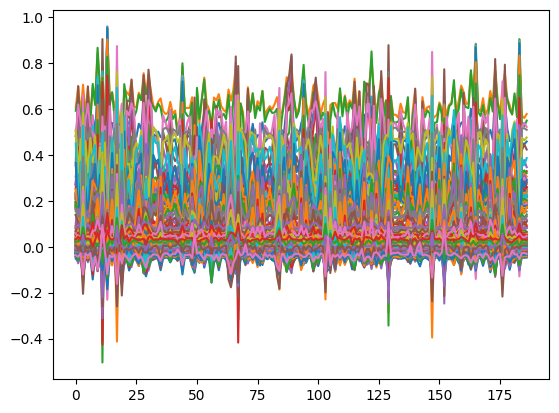

21/21 [==============================] - 2s 76ms/step - d_loss: 0.4788 - g_loss: 1.6314
Epoch 202/2000
21/21 [==============================] - 1s 24ms/step - d_loss: 0.5593 - g_loss: 1.4623
Epoch 203/2000
21/21 [==============================] - 1s 26ms/step - d_loss: 0.3664 - g_loss: 1.3184
Epoch 204/2000
21/21 [==============================] - 0s 23ms/step - d_loss: 0.4177 - g_loss: 1.5243
Epoch 205/2000
21/21 [==============================] - 1s 26ms/step - d_loss: 0.4936 - g_loss: 1.4155
Epoch 206/2000
21/21 [==============================] - 1s 28ms/step - d_loss: 0.3769 - g_loss: 1.6362
Epoch 207/2000
21/21 [==============================] - 1s 27ms/step - d_loss: 0.2976 - g_loss: 1.7373
Epoch 208/2000
21/21 [==============================] - 0s 23ms/step - d_loss: 0.3218 - g_loss: 2.0559
Epoch 209/2000
21/21 [==============================] - 1s 25ms/step - d_loss: 0.5038 - g_loss: 2.0301
Epoch 210/2000
21/21 [==============================] - 1s 25ms/step - d_loss: 0.4093 - 

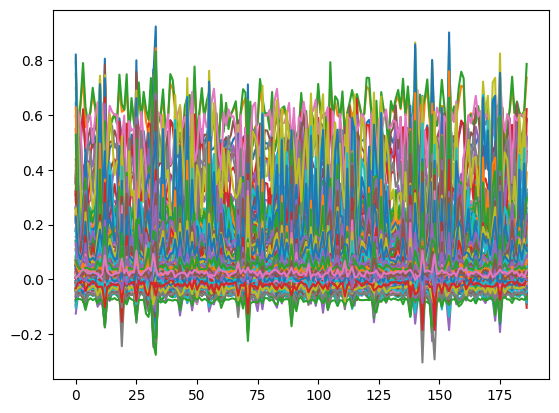

21/21 [==============================] - 1s 55ms/step - d_loss: 0.4685 - g_loss: 1.7139
Epoch 302/2000
21/21 [==============================] - 0s 22ms/step - d_loss: 0.3898 - g_loss: 1.5497
Epoch 303/2000
21/21 [==============================] - 0s 20ms/step - d_loss: 0.3643 - g_loss: 1.4964
Epoch 304/2000
21/21 [==============================] - 0s 19ms/step - d_loss: 0.4729 - g_loss: 1.4581
Epoch 305/2000
21/21 [==============================] - 0s 20ms/step - d_loss: 0.4377 - g_loss: 1.4429
Epoch 306/2000
21/21 [==============================] - 0s 20ms/step - d_loss: 0.3947 - g_loss: 1.6580
Epoch 307/2000
21/21 [==============================] - 0s 20ms/step - d_loss: 0.3393 - g_loss: 1.5814
Epoch 308/2000
21/21 [==============================] - 0s 19ms/step - d_loss: 0.4918 - g_loss: 1.7743
Epoch 309/2000
21/21 [==============================] - 0s 19ms/step - d_loss: 0.2106 - g_loss: 2.0554
Epoch 310/2000
21/21 [==============================] - 0s 20ms/step - d_loss: 0.3852 - 

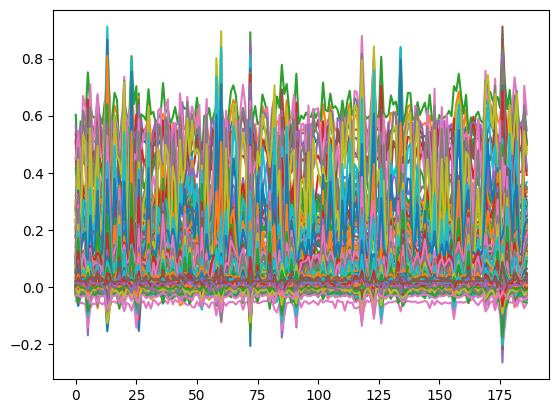

21/21 [==============================] - 1s 54ms/step - d_loss: 0.5829 - g_loss: 1.8892
Epoch 402/2000
21/21 [==============================] - 0s 22ms/step - d_loss: 0.4102 - g_loss: 1.3976
Epoch 403/2000
21/21 [==============================] - 0s 21ms/step - d_loss: 0.4947 - g_loss: 1.1741
Epoch 404/2000
21/21 [==============================] - 0s 22ms/step - d_loss: 0.4127 - g_loss: 1.2650
Epoch 405/2000
21/21 [==============================] - 0s 20ms/step - d_loss: 0.4666 - g_loss: 1.2164
Epoch 406/2000
21/21 [==============================] - 0s 19ms/step - d_loss: 0.3643 - g_loss: 1.2969
Epoch 407/2000
21/21 [==============================] - 0s 21ms/step - d_loss: 0.3810 - g_loss: 1.4372
Epoch 408/2000
21/21 [==============================] - 0s 22ms/step - d_loss: 0.4084 - g_loss: 1.4307
Epoch 409/2000
21/21 [==============================] - 0s 21ms/step - d_loss: 0.3922 - g_loss: 1.4039
Epoch 410/2000
21/21 [==============================] - 0s 20ms/step - d_loss: 0.3270 - 

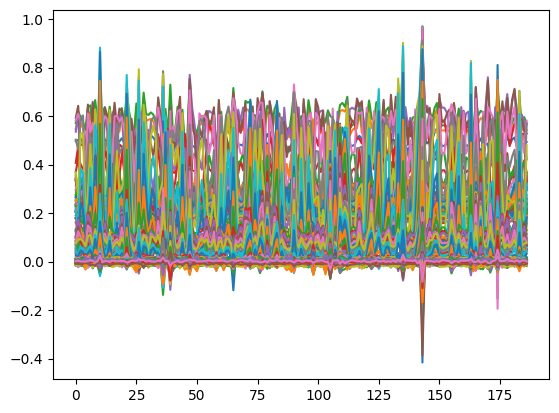

21/21 [==============================] - 2s 76ms/step - d_loss: 0.4251 - g_loss: 1.3696
Epoch 502/2000
21/21 [==============================] - 0s 22ms/step - d_loss: 0.5467 - g_loss: 1.3179
Epoch 503/2000
21/21 [==============================] - 0s 22ms/step - d_loss: 0.5260 - g_loss: 1.1053
Epoch 504/2000
21/21 [==============================] - 1s 25ms/step - d_loss: 0.5209 - g_loss: 1.2462
Epoch 505/2000
21/21 [==============================] - 0s 23ms/step - d_loss: 0.4767 - g_loss: 1.0406
Epoch 506/2000
21/21 [==============================] - 1s 24ms/step - d_loss: 0.4307 - g_loss: 1.2018
Epoch 507/2000
21/21 [==============================] - 0s 22ms/step - d_loss: 0.4575 - g_loss: 1.1296
Epoch 508/2000
21/21 [==============================] - 1s 25ms/step - d_loss: 0.5073 - g_loss: 1.1791
Epoch 509/2000
21/21 [==============================] - 0s 22ms/step - d_loss: 0.4428 - g_loss: 1.1948
Epoch 510/2000
21/21 [==============================] - 1s 24ms/step - d_loss: 0.4115 - 

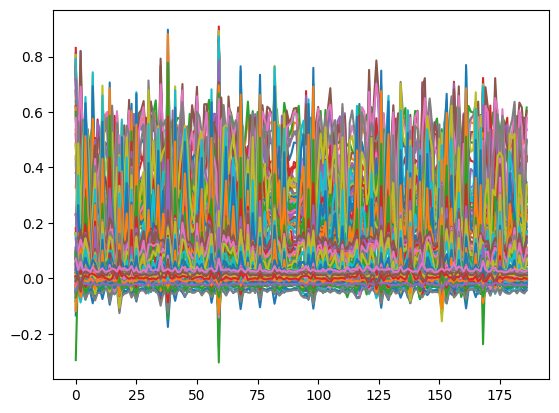

21/21 [==============================] - 2s 76ms/step - d_loss: 0.2992 - g_loss: 1.5757
Epoch 602/2000
21/21 [==============================] - 1s 32ms/step - d_loss: 0.2700 - g_loss: 2.0847
Epoch 603/2000
21/21 [==============================] - 1s 26ms/step - d_loss: 0.2714 - g_loss: 2.3686
Epoch 604/2000
21/21 [==============================] - 0s 23ms/step - d_loss: 0.1788 - g_loss: 2.4795
Epoch 605/2000
21/21 [==============================] - 1s 25ms/step - d_loss: 0.2980 - g_loss: 2.8713
Epoch 606/2000
21/21 [==============================] - 0s 23ms/step - d_loss: 0.1303 - g_loss: 3.3812
Epoch 607/2000
21/21 [==============================] - 1s 24ms/step - d_loss: 0.3200 - g_loss: 3.0004
Epoch 608/2000
21/21 [==============================] - 0s 23ms/step - d_loss: 0.3828 - g_loss: 2.4342
Epoch 609/2000
21/21 [==============================] - 0s 24ms/step - d_loss: 0.3668 - g_loss: 2.1579
Epoch 610/2000
21/21 [==============================] - 0s 23ms/step - d_loss: 0.3437 - 

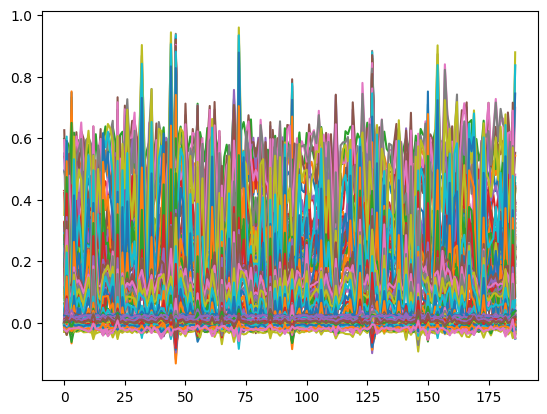

21/21 [==============================] - 2s 77ms/step - d_loss: 0.4674 - g_loss: 1.3880
Epoch 702/2000
21/21 [==============================] - 1s 24ms/step - d_loss: 0.4254 - g_loss: 1.2139
Epoch 703/2000
21/21 [==============================] - 1s 28ms/step - d_loss: 0.3568 - g_loss: 1.2784
Epoch 704/2000
21/21 [==============================] - 0s 23ms/step - d_loss: 0.4372 - g_loss: 1.5865
Epoch 705/2000
21/21 [==============================] - 0s 24ms/step - d_loss: 0.3576 - g_loss: 1.3756
Epoch 706/2000
21/21 [==============================] - 0s 22ms/step - d_loss: 0.3832 - g_loss: 1.4479
Epoch 707/2000
21/21 [==============================] - 0s 23ms/step - d_loss: 0.4185 - g_loss: 1.4898
Epoch 708/2000
21/21 [==============================] - 0s 23ms/step - d_loss: 0.2863 - g_loss: 1.4603
Epoch 709/2000
21/21 [==============================] - 1s 24ms/step - d_loss: 0.4988 - g_loss: 1.8442
Epoch 710/2000
21/21 [==============================] - 0s 23ms/step - d_loss: 0.4144 - 

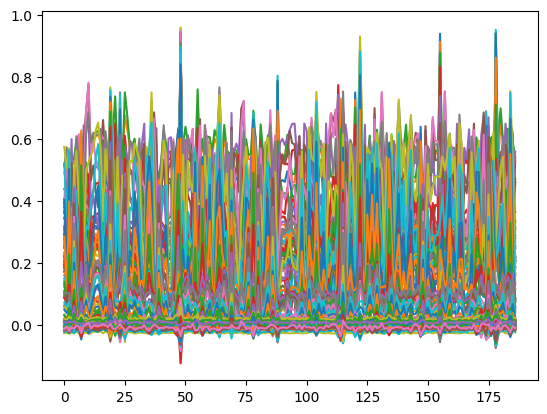

21/21 [==============================] - 1s 72ms/step - d_loss: 0.3202 - g_loss: 1.5646
Epoch 802/2000
21/21 [==============================] - 0s 23ms/step - d_loss: 0.5197 - g_loss: 1.6414
Epoch 803/2000
21/21 [==============================] - 0s 23ms/step - d_loss: 0.4861 - g_loss: 1.3566
Epoch 804/2000
21/21 [==============================] - 0s 22ms/step - d_loss: 0.3550 - g_loss: 1.2114
Epoch 805/2000
21/21 [==============================] - 0s 22ms/step - d_loss: 0.4153 - g_loss: 1.3926
Epoch 806/2000
21/21 [==============================] - 0s 23ms/step - d_loss: 0.2879 - g_loss: 1.4464
Epoch 807/2000
21/21 [==============================] - 1s 26ms/step - d_loss: 0.6309 - g_loss: 1.6401
Epoch 808/2000
21/21 [==============================] - 0s 23ms/step - d_loss: 0.4377 - g_loss: 1.1522
Epoch 809/2000
21/21 [==============================] - 1s 24ms/step - d_loss: 0.3867 - g_loss: 1.1895
Epoch 810/2000
21/21 [==============================] - 1s 26ms/step - d_loss: 0.3034 - 

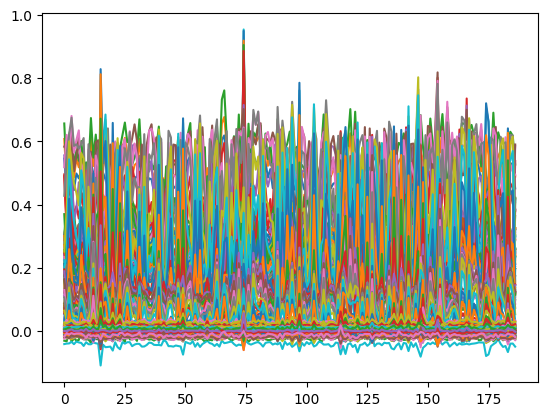

21/21 [==============================] - 2s 84ms/step - d_loss: 0.3726 - g_loss: 1.4397
Epoch 902/2000
21/21 [==============================] - 1s 31ms/step - d_loss: 0.4954 - g_loss: 1.4088
Epoch 903/2000
21/21 [==============================] - 1s 29ms/step - d_loss: 0.3759 - g_loss: 1.3229
Epoch 904/2000
21/21 [==============================] - 0s 23ms/step - d_loss: 0.4357 - g_loss: 1.3093
Epoch 905/2000
21/21 [==============================] - 1s 27ms/step - d_loss: 0.3693 - g_loss: 1.4590
Epoch 906/2000
21/21 [==============================] - 1s 29ms/step - d_loss: 0.5742 - g_loss: 1.4646
Epoch 907/2000
21/21 [==============================] - 1s 29ms/step - d_loss: 0.5413 - g_loss: 1.3576
Epoch 908/2000
21/21 [==============================] - 1s 29ms/step - d_loss: 0.4876 - g_loss: 1.1061
Epoch 909/2000
21/21 [==============================] - 1s 27ms/step - d_loss: 0.4379 - g_loss: 1.1392
Epoch 910/2000
21/21 [==============================] - 1s 27ms/step - d_loss: 0.5169 - 

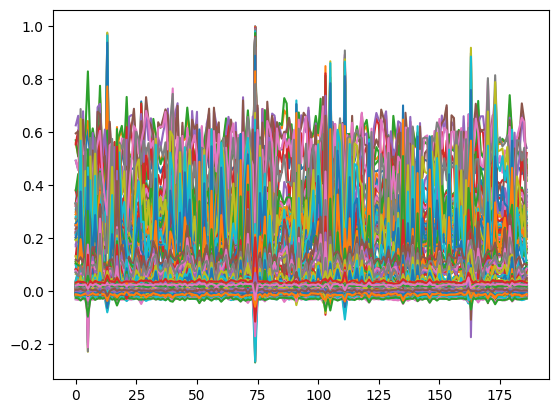

21/21 [==============================] - 1s 68ms/step - d_loss: 0.4726 - g_loss: 2.0251
Epoch 1002/2000
21/21 [==============================] - 1s 24ms/step - d_loss: 0.4580 - g_loss: 1.7369
Epoch 1003/2000
21/21 [==============================] - 0s 23ms/step - d_loss: 0.2969 - g_loss: 1.3349
Epoch 1004/2000
21/21 [==============================] - 1s 24ms/step - d_loss: 0.3133 - g_loss: 1.5873
Epoch 1005/2000
21/21 [==============================] - 0s 22ms/step - d_loss: 0.4621 - g_loss: 1.6473
Epoch 1006/2000
21/21 [==============================] - 0s 24ms/step - d_loss: 0.3298 - g_loss: 1.3514
Epoch 1007/2000
21/21 [==============================] - 0s 23ms/step - d_loss: 0.2359 - g_loss: 1.6755
Epoch 1008/2000
21/21 [==============================] - 0s 23ms/step - d_loss: 0.3848 - g_loss: 2.1327
Epoch 1009/2000
21/21 [==============================] - 0s 23ms/step - d_loss: 0.4694 - g_loss: 1.7789
Epoch 1010/2000
21/21 [==============================] - 0s 23ms/step - d_loss: 

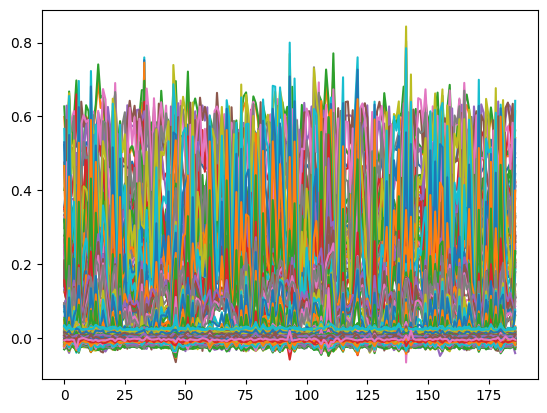

21/21 [==============================] - 1s 68ms/step - d_loss: 0.4454 - g_loss: 1.6277
Epoch 1102/2000
21/21 [==============================] - 0s 22ms/step - d_loss: 0.5001 - g_loss: 1.4064
Epoch 1103/2000
21/21 [==============================] - 1s 24ms/step - d_loss: 0.3003 - g_loss: 1.2515
Epoch 1104/2000
21/21 [==============================] - 0s 23ms/step - d_loss: 0.3082 - g_loss: 1.4893
Epoch 1105/2000
21/21 [==============================] - 1s 25ms/step - d_loss: 0.5495 - g_loss: 1.6607
Epoch 1106/2000
21/21 [==============================] - 0s 23ms/step - d_loss: 0.4129 - g_loss: 1.2900
Epoch 1107/2000
21/21 [==============================] - 1s 27ms/step - d_loss: 0.3111 - g_loss: 1.3487
Epoch 1108/2000
21/21 [==============================] - 1s 30ms/step - d_loss: 0.4562 - g_loss: 1.6265
Epoch 1109/2000
21/21 [==============================] - 1s 31ms/step - d_loss: 0.5431 - g_loss: 1.4254
Epoch 1110/2000
21/21 [==============================] - 1s 31ms/step - d_loss: 

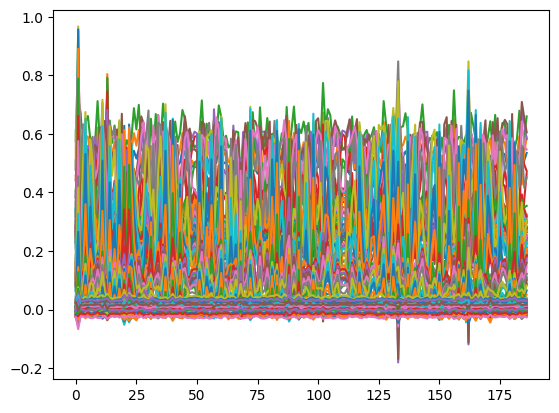

21/21 [==============================] - 1s 73ms/step - d_loss: 0.4415 - g_loss: 1.5887
Epoch 1202/2000
21/21 [==============================] - 0s 24ms/step - d_loss: 0.4002 - g_loss: 1.3023
Epoch 1203/2000
21/21 [==============================] - 1s 24ms/step - d_loss: 0.4076 - g_loss: 1.5360
Epoch 1204/2000
21/21 [==============================] - 1s 26ms/step - d_loss: 0.4885 - g_loss: 1.5424
Epoch 1205/2000
21/21 [==============================] - 1s 29ms/step - d_loss: 0.4276 - g_loss: 1.5316
Epoch 1206/2000
21/21 [==============================] - 1s 24ms/step - d_loss: 0.3851 - g_loss: 1.4084
Epoch 1207/2000
21/21 [==============================] - 1s 27ms/step - d_loss: 0.4985 - g_loss: 1.3310
Epoch 1208/2000
21/21 [==============================] - 1s 28ms/step - d_loss: 0.4914 - g_loss: 1.1507
Epoch 1209/2000
21/21 [==============================] - 1s 27ms/step - d_loss: 0.4110 - g_loss: 1.1353
Epoch 1210/2000
21/21 [==============================] - 1s 28ms/step - d_loss: 

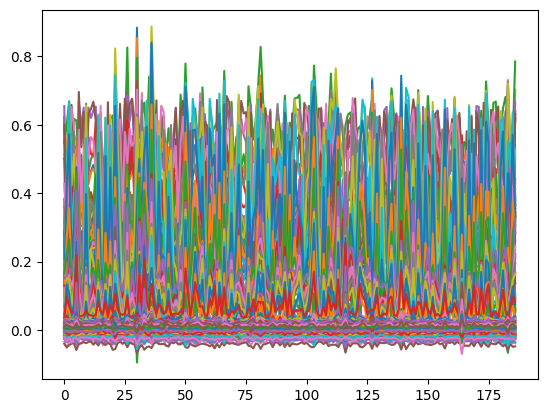

21/21 [==============================] - 2s 80ms/step - d_loss: 0.5346 - g_loss: 1.6926
Epoch 1302/2000
21/21 [==============================] - 1s 30ms/step - d_loss: 0.4505 - g_loss: 1.0556
Epoch 1303/2000
21/21 [==============================] - 1s 30ms/step - d_loss: 0.4395 - g_loss: 1.0459
Epoch 1304/2000
21/21 [==============================] - 1s 24ms/step - d_loss: 0.4072 - g_loss: 1.1648
Epoch 1305/2000
21/21 [==============================] - 0s 23ms/step - d_loss: 0.4870 - g_loss: 1.1324
Epoch 1306/2000
21/21 [==============================] - 0s 22ms/step - d_loss: 0.4425 - g_loss: 1.2343
Epoch 1307/2000
21/21 [==============================] - 0s 22ms/step - d_loss: 0.4778 - g_loss: 1.1227
Epoch 1308/2000
21/21 [==============================] - 0s 23ms/step - d_loss: 0.5353 - g_loss: 1.3745
Epoch 1309/2000
21/21 [==============================] - 0s 22ms/step - d_loss: 0.4326 - g_loss: 1.1990
Epoch 1310/2000
21/21 [==============================] - 0s 23ms/step - d_loss: 

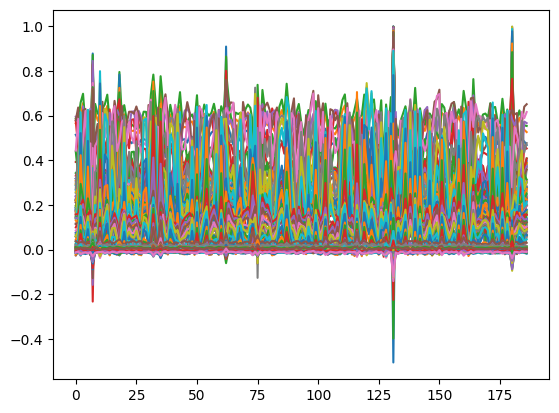

21/21 [==============================] - 2s 96ms/step - d_loss: 0.4792 - g_loss: 1.1677
Epoch 1402/2000
21/21 [==============================] - 1s 25ms/step - d_loss: 0.4293 - g_loss: 1.1947
Epoch 1403/2000
21/21 [==============================] - 1s 24ms/step - d_loss: 0.4116 - g_loss: 1.1108
Epoch 1404/2000
21/21 [==============================] - 1s 24ms/step - d_loss: 0.3697 - g_loss: 1.4324
Epoch 1405/2000
21/21 [==============================] - 0s 24ms/step - d_loss: 0.4516 - g_loss: 1.4844
Epoch 1406/2000
21/21 [==============================] - 1s 23ms/step - d_loss: 0.5083 - g_loss: 1.4105
Epoch 1407/2000
21/21 [==============================] - 0s 23ms/step - d_loss: 0.3570 - g_loss: 1.3545
Epoch 1408/2000
21/21 [==============================] - 1s 25ms/step - d_loss: 0.4506 - g_loss: 1.3843
Epoch 1409/2000
21/21 [==============================] - 1s 24ms/step - d_loss: 0.3627 - g_loss: 1.3227
Epoch 1410/2000
21/21 [==============================] - 1s 25ms/step - d_loss: 

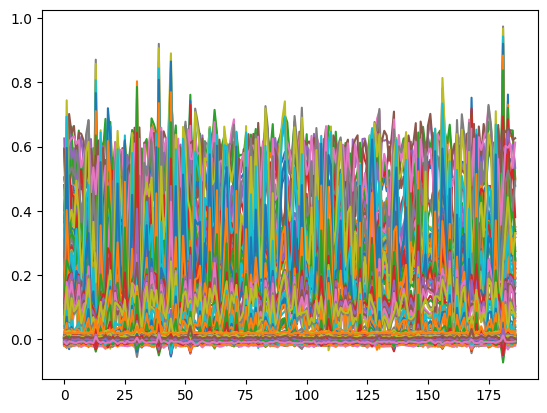

21/21 [==============================] - 2s 82ms/step - d_loss: 0.4169 - g_loss: 1.3304
Epoch 1502/2000
21/21 [==============================] - 1s 28ms/step - d_loss: 0.4580 - g_loss: 1.2950
Epoch 1503/2000
21/21 [==============================] - 1s 28ms/step - d_loss: 0.4569 - g_loss: 1.2358
Epoch 1504/2000
21/21 [==============================] - 1s 29ms/step - d_loss: 0.4210 - g_loss: 1.2806
Epoch 1505/2000
21/21 [==============================] - 1s 29ms/step - d_loss: 0.4178 - g_loss: 1.3232
Epoch 1506/2000
21/21 [==============================] - 1s 25ms/step - d_loss: 0.4191 - g_loss: 1.3966
Epoch 1507/2000
21/21 [==============================] - 1s 28ms/step - d_loss: 0.4808 - g_loss: 1.3903
Epoch 1508/2000
21/21 [==============================] - 1s 30ms/step - d_loss: 0.4375 - g_loss: 1.1910
Epoch 1509/2000
21/21 [==============================] - 1s 31ms/step - d_loss: 0.4086 - g_loss: 1.2848
Epoch 1510/2000
21/21 [==============================] - 1s 27ms/step - d_loss: 

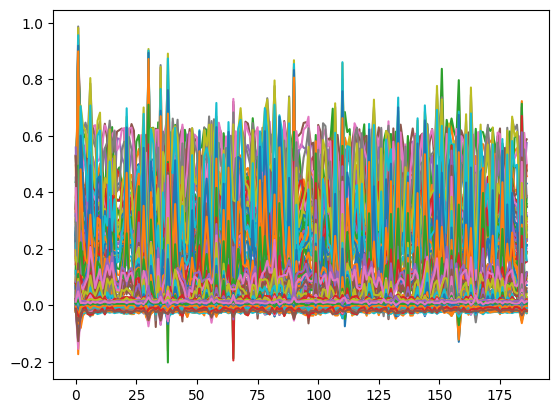

21/21 [==============================] - 1s 73ms/step - d_loss: 0.3064 - g_loss: 1.6495
Epoch 1602/2000
21/21 [==============================] - 0s 22ms/step - d_loss: 0.3985 - g_loss: 1.7519
Epoch 1603/2000
21/21 [==============================] - 0s 22ms/step - d_loss: 0.4217 - g_loss: 1.7655
Epoch 1604/2000
21/21 [==============================] - 0s 23ms/step - d_loss: 0.4555 - g_loss: 1.6200
Epoch 1605/2000
21/21 [==============================] - 1s 24ms/step - d_loss: 0.4835 - g_loss: 1.3760
Epoch 1606/2000
21/21 [==============================] - 0s 22ms/step - d_loss: 0.3569 - g_loss: 1.3156
Epoch 1607/2000
21/21 [==============================] - 0s 23ms/step - d_loss: 0.4447 - g_loss: 1.4401
Epoch 1608/2000
21/21 [==============================] - 0s 22ms/step - d_loss: 0.3830 - g_loss: 1.3900
Epoch 1609/2000
21/21 [==============================] - 0s 23ms/step - d_loss: 0.4800 - g_loss: 1.6165
Epoch 1610/2000
21/21 [==============================] - 1s 24ms/step - d_loss: 

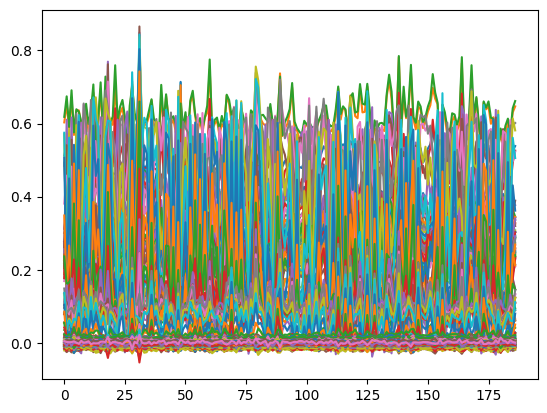

21/21 [==============================] - 1s 68ms/step - d_loss: 0.4005 - g_loss: 1.2384
Epoch 1702/2000
21/21 [==============================] - 1s 24ms/step - d_loss: 0.4103 - g_loss: 1.3484
Epoch 1703/2000
21/21 [==============================] - 1s 28ms/step - d_loss: 0.4605 - g_loss: 1.3507
Epoch 1704/2000
21/21 [==============================] - 1s 31ms/step - d_loss: 0.3821 - g_loss: 1.4542
Epoch 1705/2000
21/21 [==============================] - 1s 31ms/step - d_loss: 0.3939 - g_loss: 1.7159
Epoch 1706/2000
21/21 [==============================] - 1s 30ms/step - d_loss: 0.3695 - g_loss: 1.3637
Epoch 1707/2000
21/21 [==============================] - 1s 27ms/step - d_loss: 0.5059 - g_loss: 1.6971
Epoch 1708/2000
21/21 [==============================] - 1s 30ms/step - d_loss: 0.3652 - g_loss: 1.2423
Epoch 1709/2000
21/21 [==============================] - 1s 29ms/step - d_loss: 0.3430 - g_loss: 1.5013
Epoch 1710/2000
21/21 [==============================] - 1s 29ms/step - d_loss: 

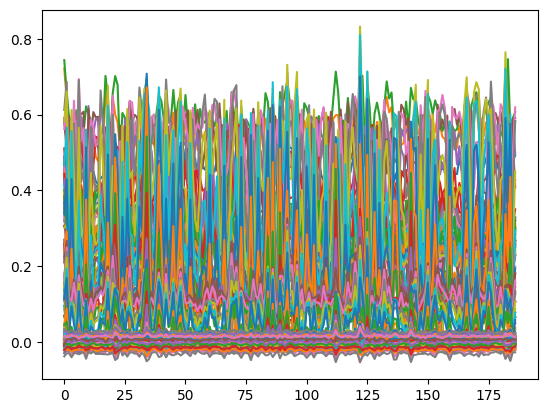

21/21 [==============================] - 2s 84ms/step - d_loss: 0.5989 - g_loss: 1.9770
Epoch 1802/2000
21/21 [==============================] - 1s 28ms/step - d_loss: 0.4391 - g_loss: 1.2969
Epoch 1803/2000
21/21 [==============================] - 1s 30ms/step - d_loss: 0.3915 - g_loss: 1.2418
Epoch 1804/2000
21/21 [==============================] - 1s 29ms/step - d_loss: 0.3573 - g_loss: 1.2852
Epoch 1805/2000
21/21 [==============================] - 1s 33ms/step - d_loss: 0.3094 - g_loss: 1.1780
Epoch 1806/2000
21/21 [==============================] - 1s 27ms/step - d_loss: 0.3136 - g_loss: 1.5725
Epoch 1807/2000
21/21 [==============================] - 1s 29ms/step - d_loss: 0.2500 - g_loss: 1.7402
Epoch 1808/2000
21/21 [==============================] - 1s 27ms/step - d_loss: 0.4029 - g_loss: 1.9465
Epoch 1809/2000
21/21 [==============================] - 1s 24ms/step - d_loss: 0.4507 - g_loss: 1.6868
Epoch 1810/2000
21/21 [==============================] - 0s 23ms/step - d_loss: 

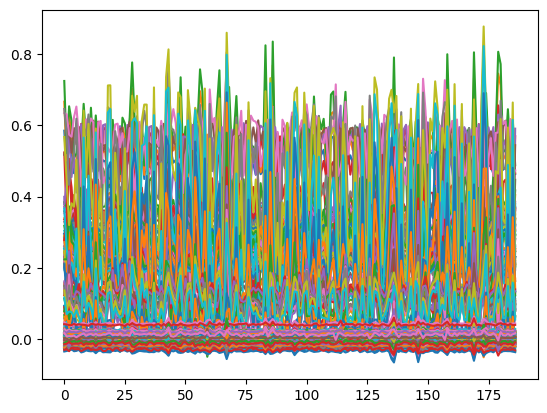

21/21 [==============================] - 1s 69ms/step - d_loss: 0.5654 - g_loss: 1.9951
Epoch 1902/2000
21/21 [==============================] - 0s 22ms/step - d_loss: 0.4240 - g_loss: 1.4236
Epoch 1903/2000
21/21 [==============================] - 0s 22ms/step - d_loss: 0.2535 - g_loss: 1.3987
Epoch 1904/2000
21/21 [==============================] - 0s 22ms/step - d_loss: 0.3030 - g_loss: 1.7345
Epoch 1905/2000
21/21 [==============================] - 0s 23ms/step - d_loss: 0.2304 - g_loss: 1.5109
Epoch 1906/2000
21/21 [==============================] - 0s 24ms/step - d_loss: 0.1530 - g_loss: 1.8599
Epoch 1907/2000
21/21 [==============================] - 0s 23ms/step - d_loss: 0.2160 - g_loss: 2.0975
Epoch 1908/2000
21/21 [==============================] - 0s 23ms/step - d_loss: 0.6100 - g_loss: 2.5654
Epoch 1909/2000
21/21 [==============================] - 0s 23ms/step - d_loss: 0.3846 - g_loss: 1.4820
Epoch 1910/2000
21/21 [==============================] - 0s 23ms/step - d_loss: 

In [63]:
cbk = keras.callbacks.LambdaCallback(on_epoch_end=lambda epoch,logs: show_samples(epoch, gan.generator, four))
%time hist = gan.fit(four, epochs=2000, callbacks=[cbk], verbose=True)
gan.save_weights('/content/drive/MyDrive/ecg/architektura3/four2000epok50latentdim')


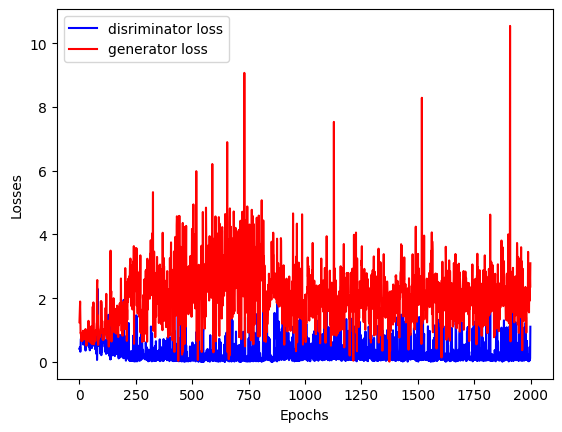

In [49]:
plt.plot(hist.history['d_loss'], color='blue', label='disriminator loss')
plt.plot(hist.history['g_loss'], color='red', label='generator loss')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.legend()

WAGI DLA 2

In [69]:
def do_data(nums):
    result = []
    latent_dim = 50
    num_samples_to_generate = 1

    for i in range(nums):
        # Generate new set of noise for each iteration
        latent_points = tf.random.normal(shape=(num_samples_to_generate, latent_dim))

        # Use the trained generator to generate data
        generated_data = generator(latent_points)

        # Squeeze the batch dimension, leaving (187, 1)
        generated_data = tf.squeeze(generated_data, axis=0)

        # Convert the TensorFlow tensor to a NumPy array
        generated_data_np = generated_data.numpy()

        # Add the generated data to the result list
        result.append(generated_data_np)

    # Convert the list to a NumPy array
    return np.array(result)

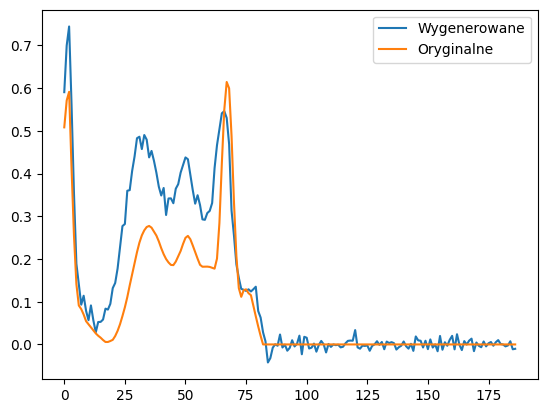

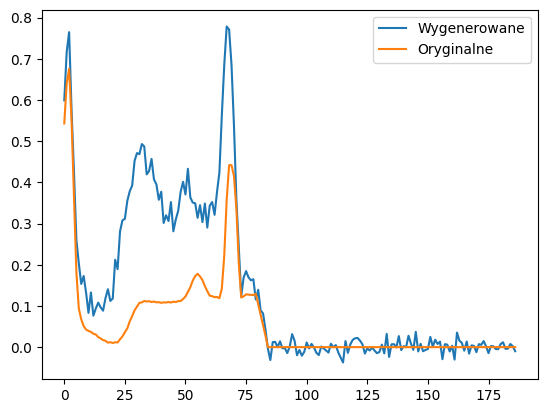

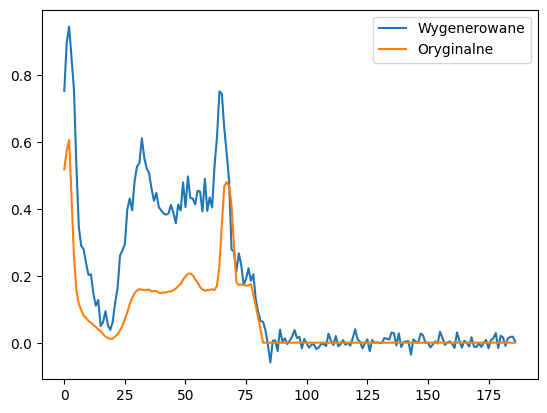

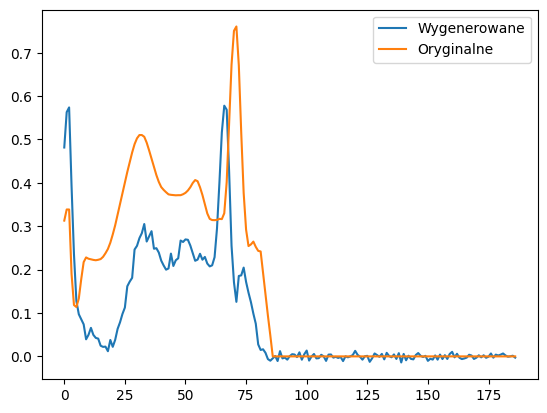

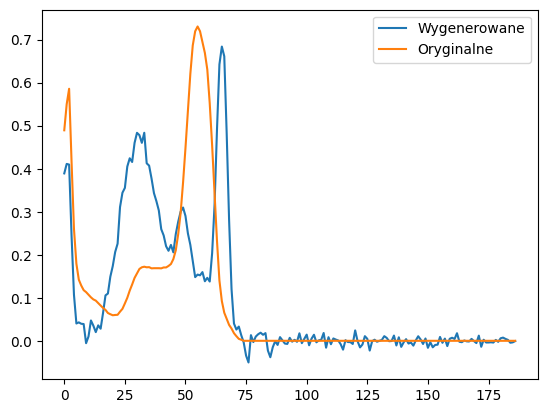

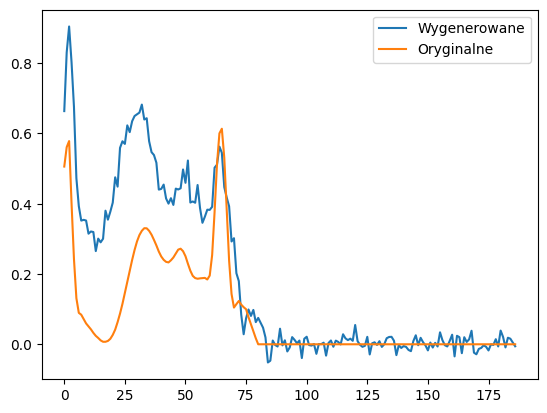

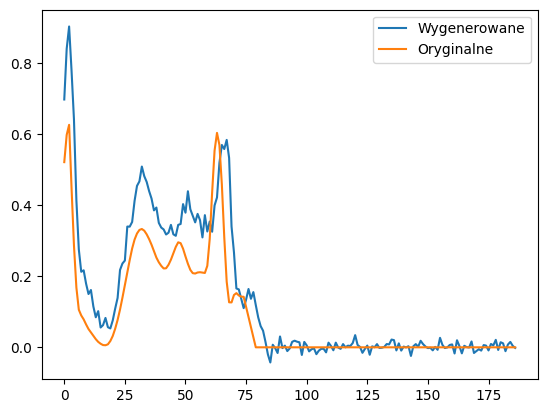

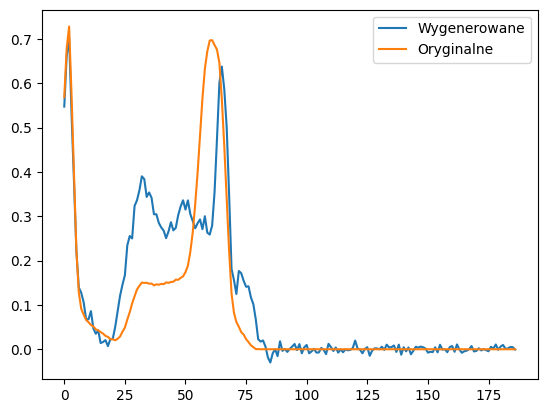

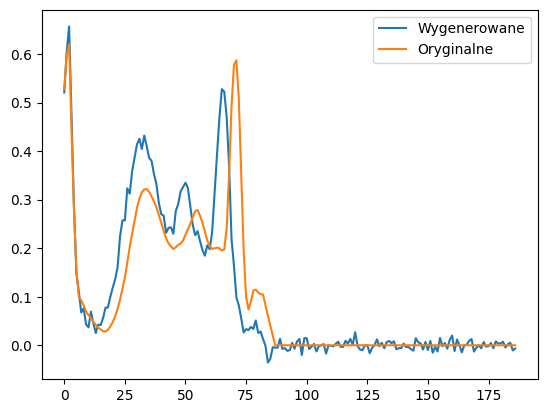

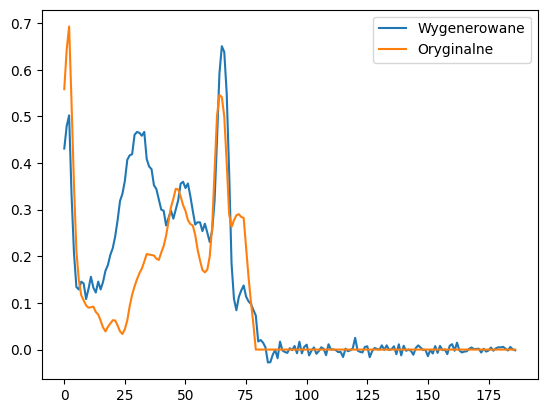

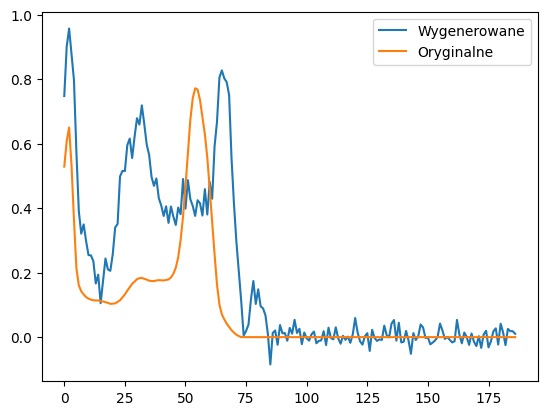

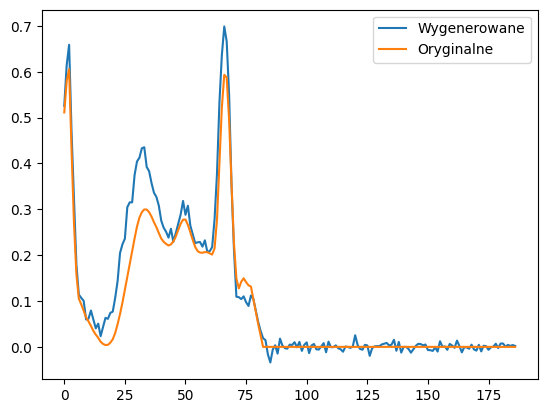

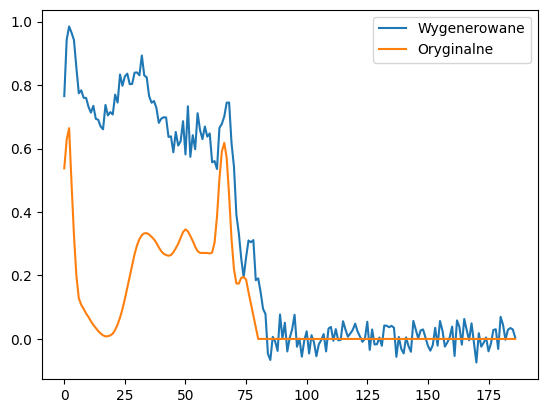

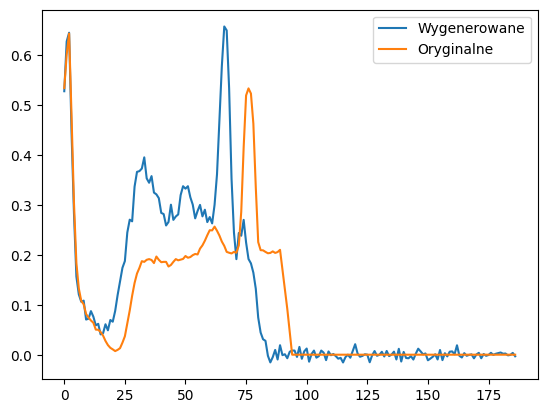

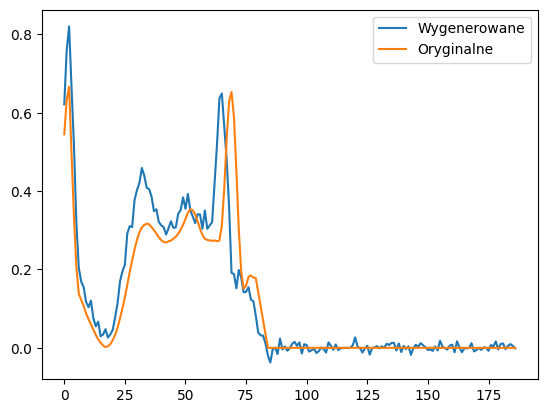

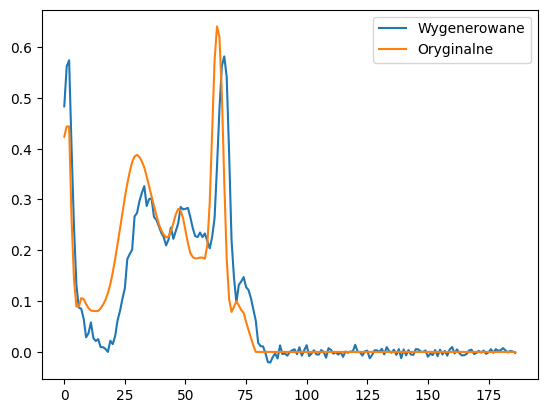

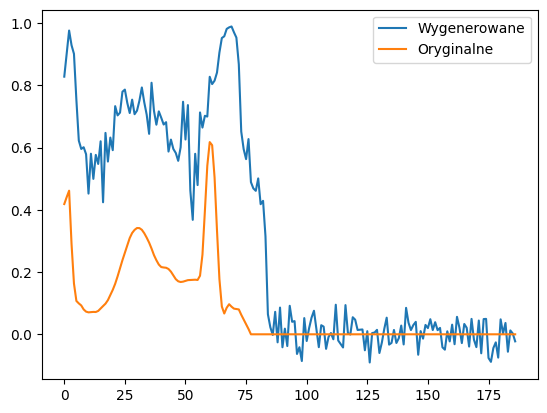

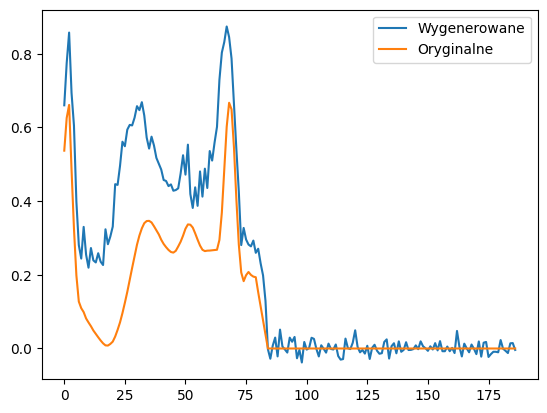

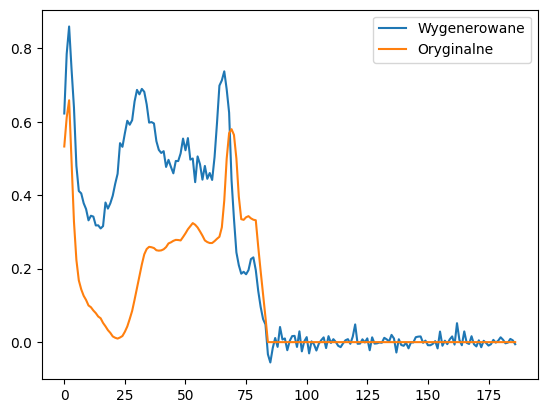

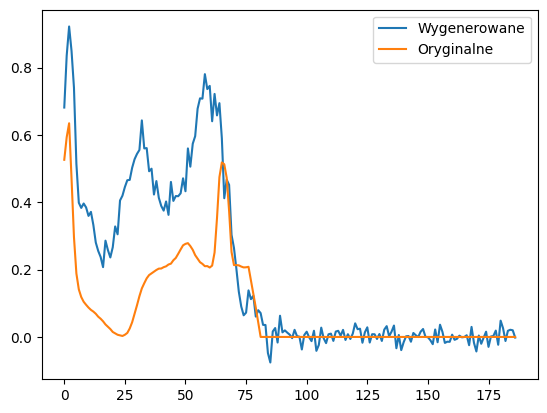

In [77]:
fours=do_data(20)

for i in range(len(fours)):
    plt.figure()
    plt.plot(fours[i], label='Wygenerowane')
    plt.plot(four[i], label='Oryginalne')

    # Dodanie legendy do wykresu
    plt.legend()

    # Wyświetlenie wykresu
    plt.show()

In [78]:
from google.colab import files
fours=do_data(5000-len(four))
np.savetxt('fours.csv', fours, delimiter=',')

files.download('fours.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [73]:
print(len(four))
print(5000-len(four))

641
4359


In [79]:
loaded_array = np.loadtxt('fours.csv', delimiter=',')

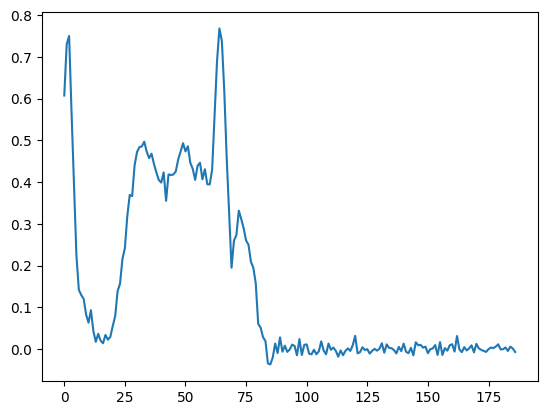

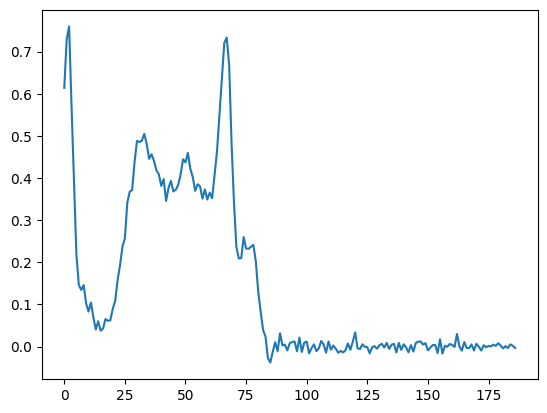

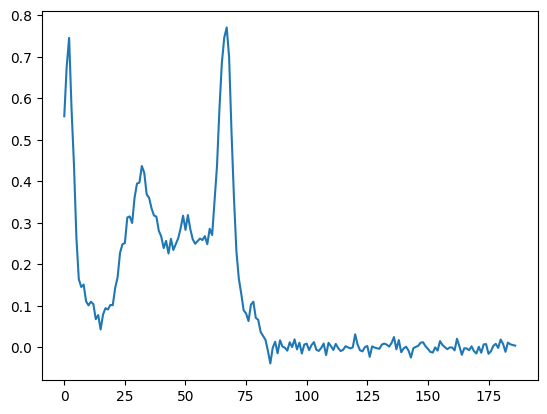

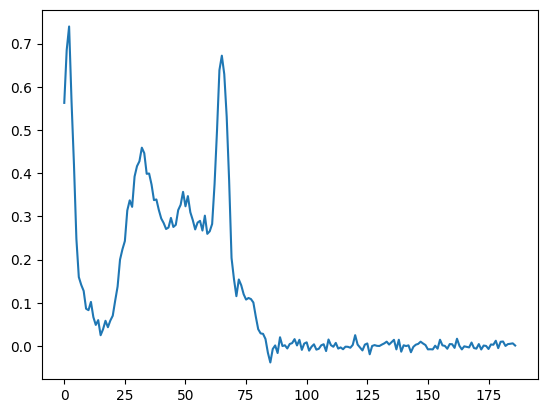

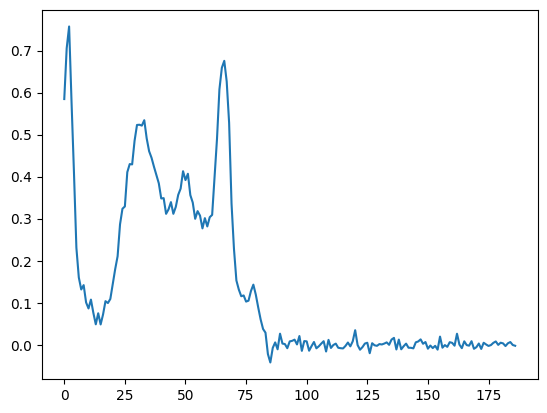

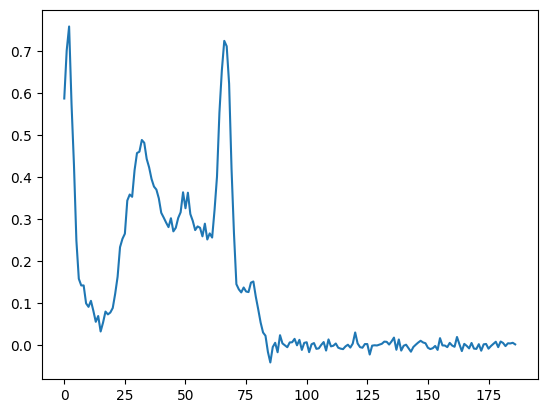

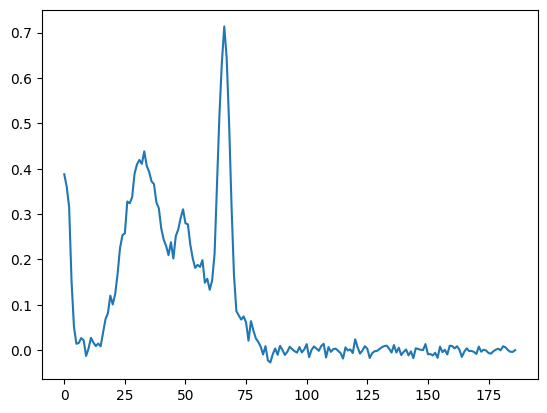

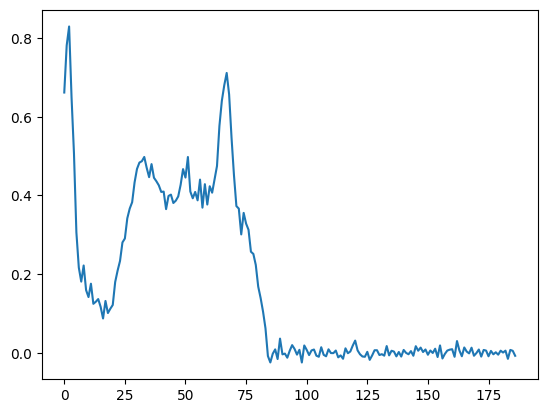

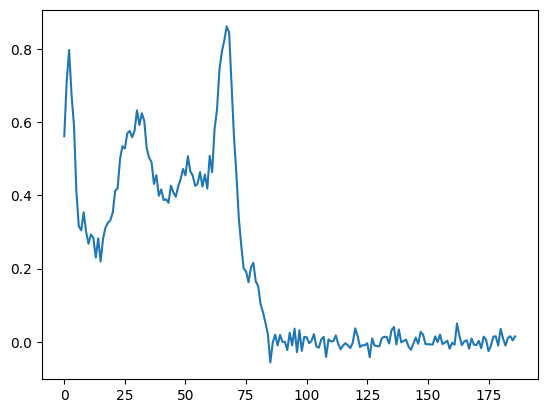

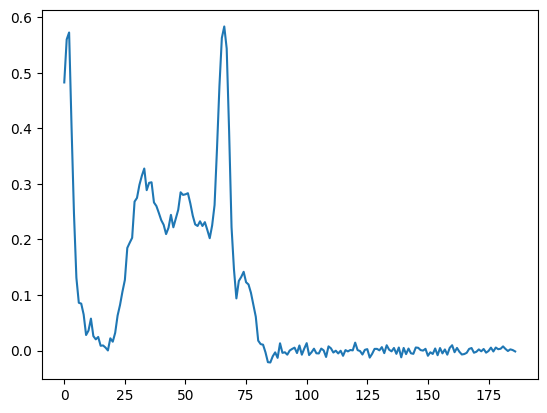

In [80]:
for i in range(10):
    plt.figure()
    plt.plot(loaded_array[i], label='Wygenerowane')